# First Iteration with Recurrent Neural Networks and Post Padding

In [6]:
import pandas as pd
import numpy as np
from progress.bar import Bar
#from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical, pad_sequences

In [2]:
df = pd.read_csv("./Metadata/data_curated.csv")
df.set_index("File", inplace=True)
df.head()

,Class
File,
S1V3C1M3A Clip166.npy,1
S1V1C1M1A Clip18.npy,1
S1V4C1M4A Clip241.npy,1
S1V4C1M4A Clip239.npy,1
S1V4C1M4A Clip245.npy,1


In [62]:
X_list = []
y_list = []
with Bar("Processing...", max = df.size) as bar:
    for file_name, class_name in df.iterrows():
        np_element = np.load(f"../Clean_Data/{class_name.iloc[0]}/{file_name}").T
        padding_element = pad_sequences(np_element,maxlen=97, padding='post', value=0.01)
        X_list.append(padding_element.T)#[:33,:])
        y_list.append(class_name.iloc[0])
        bar.next()

In [49]:
min_arr = 1000
for arr in X_list:
    aux_arr = arr.shape[0]
    if aux_arr < min_arr:
        min_arr = aux_arr
print(min_arr)

97


In [50]:
max_arr = 0
for arr in X_list:
    aux_arr = arr.shape[0]
    if aux_arr > max_arr:
        max_arr = aux_arr
print(max_arr)

97


In [63]:
pad_sequences(X_list[0].T, maxlen=97, padding='post').shape

(1662, 97)

In [64]:
X_list[0].shape

(97, 1662)

In [65]:
X = np.stack(X_list)
y = np.array(y_list)

In [66]:
X.shape

(1500, 97, 1662)

In [67]:
y.shape

(1500,)

# GaussianHMM

# Recurrent Neural Networks

In [68]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(97,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [69]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [70]:
y = to_categorical(y)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [72]:
y_test.shape

(450, 6)

In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 97, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 97, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 596774 (2.28 MB)
Trainable params: 59677

In [74]:
model.fit(X_train, y_train, epochs=50, batch_size=128)

Epoch 1/50
9/9 [==============================] - 22s 1s/step - loss: 1.7883 - categorical_accuracy: 0.2000
Epoch 2/50
9/9 [==============================] - 12s 1s/step - loss: 1.7783 - categorical_accuracy: 0.2019
Epoch 3/50
9/9 [==============================] - 12s 1s/step - loss: 34748.0859 - categorical_accuracy: 0.1848
Epoch 4/50
9/9 [==============================] - 12s 1s/step - loss: 3.9027 - categorical_accuracy: 0.2267
Epoch 5/50
9/9 [==============================] - 12s 1s/step - loss: 1.7448 - categorical_accuracy: 0.2114
Epoch 6/50
9/9 [==============================] - 12s 1s/step - loss: 1.7402 - categorical_accuracy: 0.2010
Epoch 7/50
9/9 [==============================] - 11s 1s/step - loss: 1.7344 - categorical_accuracy: 0.2010
Epoch 8/50
9/9 [==============================] - 11s 1s/step - loss: 1.7289 - categorical_accuracy: 0.2038
Epoch 9/50
9/9 [==============================] - 12s 1s/step - loss: 1.7235 - categorical_accuracy: 0.2086
Epoch 10/50
9/9 [=======

In [75]:
y_pred = model.predict(X_test)

15/15 [==============================] - 4s 177ms/step


In [76]:
y_pred = np.argmax(y_pred, axis=1).tolist()

In [77]:
y_true = np.argmax(y_test, axis=1).tolist()

In [78]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,ConfusionMatrixDisplay, confusion_matrix

In [79]:
confusion_matrices = confusion_matrix(y_true, y_pred,labels=np.unique(y_pred), normalize='true')

In [80]:
confusion_matrices

array([[0.27472527, 0.04395604, 0.68131868],
       [0.38271605, 0.04938272, 0.56790123],
       [0.15730337, 0.        , 0.84269663]])

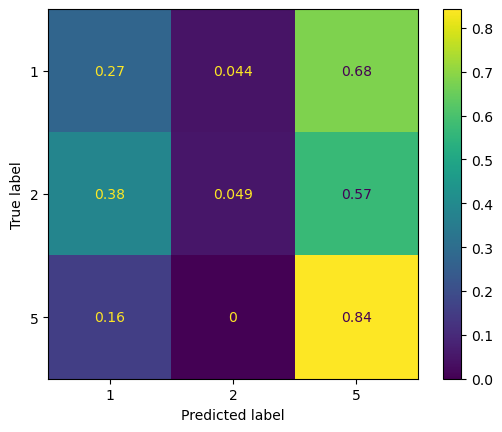

In [81]:
disp = ConfusionMatrixDisplay(confusion_matrices, display_labels=np.unique(y_pred))
disp.plot()